In [35]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import utils
import plotting
import os
import glob
import csv, os
import pandas as pd
import nilearn
from nilearn import surface
import warnings
warnings.filterwarnings('ignore')
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels

In [36]:
# 1. specify the subjects and directories
subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015','PNC016', 'PNC018','PNC019']
micapipe_dir = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_PNI/rawdata'
hippunfold_dir='/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold'
tmp_dir = 'tmp_func'
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# 2. Prepare data and analysis parameters 
ses = '01'
hemis = ['L','R']
labels= ['hipp','dentate'] 
tasks= ['patternsep2', 'epiencode','epiretrieve']
t_r = 1.69 
slice_time_ref = 0.0
sigma = 3 #Gaussian smoothing kernal sigma (mm)
ind = [range(419), range(419,483)] # index of how many dentate and hipp vertices are

# 3. Load neocortical surfaces for visualzation 
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))
c69_inf_lh= read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
labeling = load_parcellation('schaefer', scale=400, join=True)

atlas = 'schaefer-400'
# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)
# Mask of the medial wall
mask_c69 = labels_c69 != 0

In [37]:
#create helper function to generate and save gifti images later 
def create_nifti_image(data, sub, hemi, contrast_id, output_dir):
    # Create data arrays
    data_array_neo = nib.gifti.GiftiDataArray(data=data[:200, ])
    data_array_hipp = nib.gifti.GiftiDataArray(data=data[200:619, ])
    data_array_dg = nib.gifti.GiftiDataArray(data=data[619:, ])

    # Create NIfTI images
    image_neo = nib.gifti.GiftiImage()
    image_hipp = nib.gifti.GiftiImage()
    image_dg = nib.gifti.GiftiImage()

    # Add data arrays to images
    image_neo.add_gifti_data_array(data_array_neo)
    image_hipp.add_gifti_data_array(data_array_hipp)
    image_dg.add_gifti_data_array(data_array_dg)

    # Save NIfTI images
    nib.save(image_neo, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-{current_task}_contrast-{contrast_id}.shape.gii')
    nib.save(image_hipp, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_task-{current_task}_contrast-{contrast_id}.shape.gii')
    nib.save(image_dg, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_task-{current_task}_contrast-{contrast_id}.shape.gii')


# 0. Map PatternSeparation2 and Episodic Memory data to hippocampal surface

In [ ]:
!mkdir -p {tmp_dir}
shp = [419,64]
for sub in subs:

    for task in tasks:
        os.makedirs(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{task}')

        # convert affines 
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-{task}_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-{task}_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}

                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-{task}_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-{task}_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/{task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_{task}_smooth-{sigma}mm.func.gii')
!rm -r {tmp_dir}

# 1. GLM fit pattern separation2

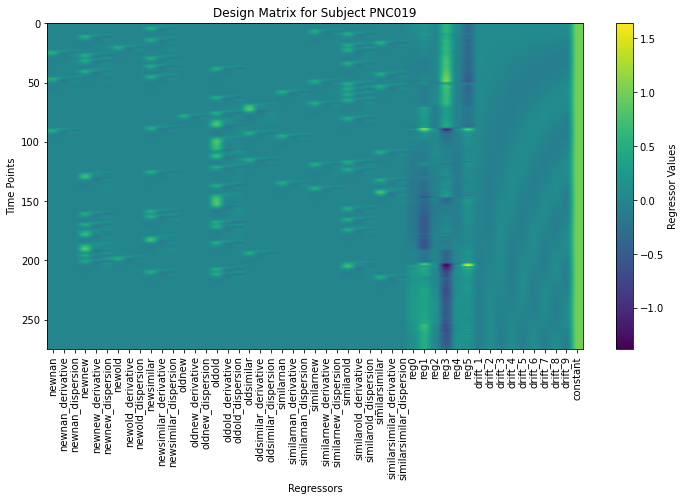

In [38]:
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']
current_task='patternsep2'

for sub in subs:
    
    # Specify the timing of fmri frames from one example
    motion_reg = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-patternsep2_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load event files
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-patternsep2_events.tsv'
    events = pd.read_table(events_file)
    # Recode events to include fixation, stimulus, key press/response to soak up variance
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    # Combine response and condition to get all possible combinations
    true_con = events['condition'] + events["subject response"].astype('str')
    df['trial_type'] = true_con
    
    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg)
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'patternseparation_uncorrected': (
        basic_contrasts['similarsimilar']
        + basic_contrasts['similarsimilar_derivative']
        + basic_contrasts['similarsimilar_dispersion']),
    'patterncompletion_uncorrected': (
        basic_contrasts['oldsimilar']
        + basic_contrasts['oldsimilar_derivative']
        + basic_contrasts['oldsimilar_dispersion']),
    'noveltydetection_uncorrected': (
        basic_contrasts['newnew']
        + basic_contrasts['newnew_derivative']
        + basic_contrasts['newnew_dispersion']),

    'patternseparation': (
        basic_contrasts['similarsimilar']
        - basic_contrasts['similarnew']
        + basic_contrasts['similarsimilar_derivative']
        - basic_contrasts['similarnew_derivative']
        + basic_contrasts['similarsimilar_dispersion']
        - basic_contrasts['similarnew_dispersion']),
    'patterncompletion': (
        basic_contrasts['oldsimilar']
        - basic_contrasts['oldnew']
        + basic_contrasts['oldsimilar_derivative']
        - basic_contrasts['oldnew_derivative']
        + basic_contrasts['oldsimilar_dispersion']
        - basic_contrasts['oldnew_dispersion']),
    'noveltydetection': (
        basic_contrasts['newnew']
        - 0.5*basic_contrasts['oldsimilar']
        - 0.5*basic_contrasts['oldnew']
        + basic_contrasts['newnew_derivative']
        - 0.5*basic_contrasts['oldsimilar_derivative']
        - 0.5*basic_contrasts['oldnew_derivative']
        + basic_contrasts['newnew_dispersion']
        - 0.5*basic_contrasts['oldsimilar_dispersion']
        - 0.5*basic_contrasts['oldnew_dispersion'])}
    
    
    ### Load the neocortical and hippocampal/dentate timeseries ###
    
    # Load the neocortical timeseries and dowmsample to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-patternsep2_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_patternsep2_smooth-3mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_patternsep2_smooth-3mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        ### fit the design matrix to the data
        labels_, estimates = run_glm(combined_array[0:210, :], design_matrix.values[0:210])

        ### run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
            
            #create and save gifti images 
            create_nifti_image(z_score, sub, hemi, contrast_id, hippunfold_dir)
            
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='viridis')
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns[0:210], rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()


# 1.1 Plot contrasts to surfaces 

In [39]:
#plot hippocampal findings 
contrast_names=list(contrasts.keys())
contrasts_patternsep2 = np.ones((483, 2, len(subs), len(contrast_names))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrast_names):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-patternsep2_contrast-{contrast_name}.shape.gii'
                try:
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_patternsep2[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrast_name}')

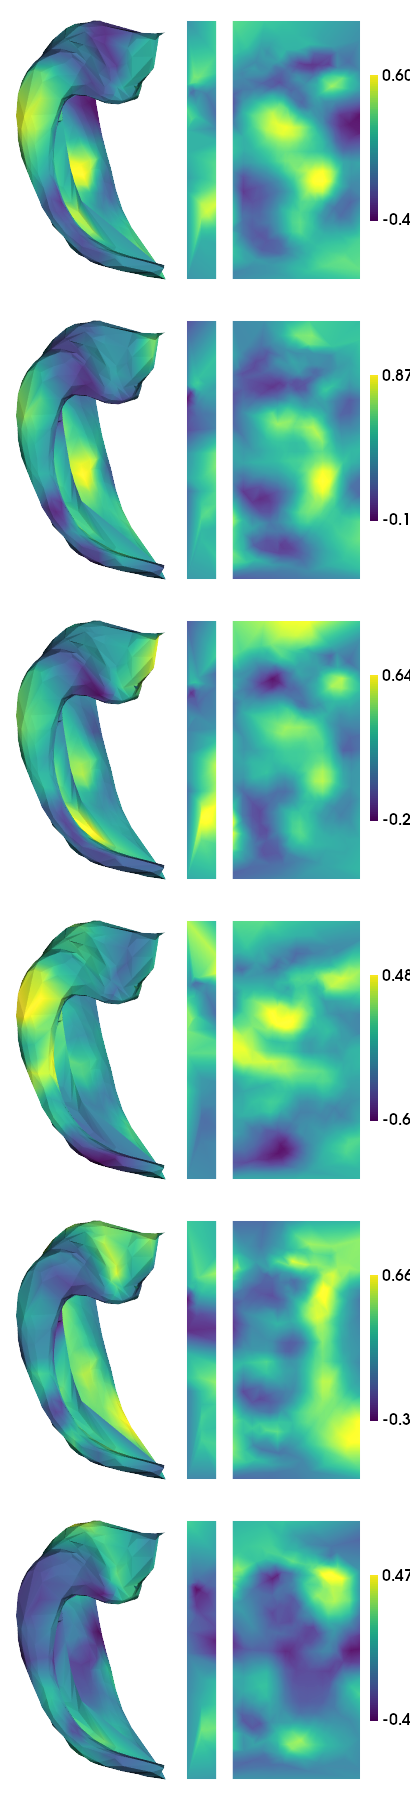

In [40]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), hemis=['L'], den='2mm', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

In [41]:
#plot neocortical findings 
contrasts_patternsep2_neo = np.ones((len(subs), 6, 2, 200)) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrast_names):
            contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/patternsep2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-patternsep2_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_patternsep2_neo[s, c, h] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrast_name}')

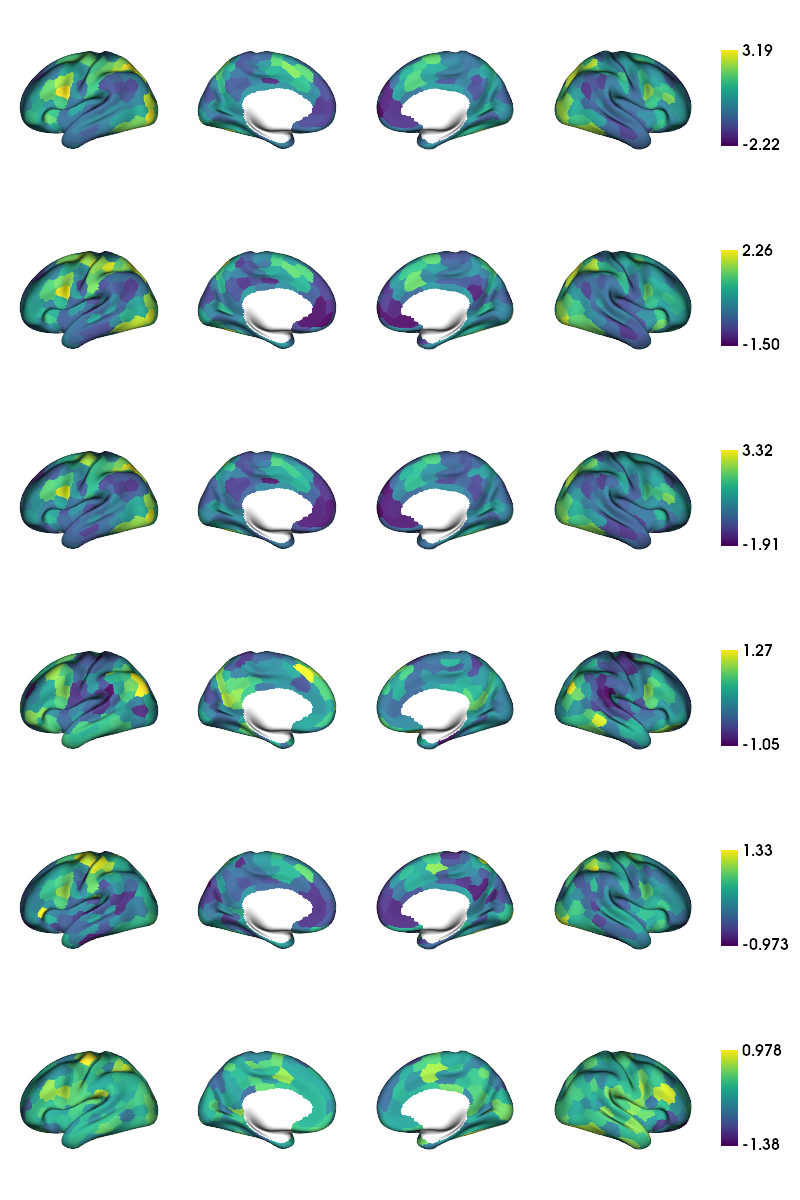

In [42]:
a=np.nanmean(contrasts_patternsep2_neo,axis=0)
reshaped_a = a.reshape(a.shape[0], a.shape[1] * a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[0]):
    mapped = map_to_labels(reshaped_a[i, :], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, embed_nb=True, nan_color=(1, 1, 1, 1))

# 2.0 GLM fit for episodic retrieval

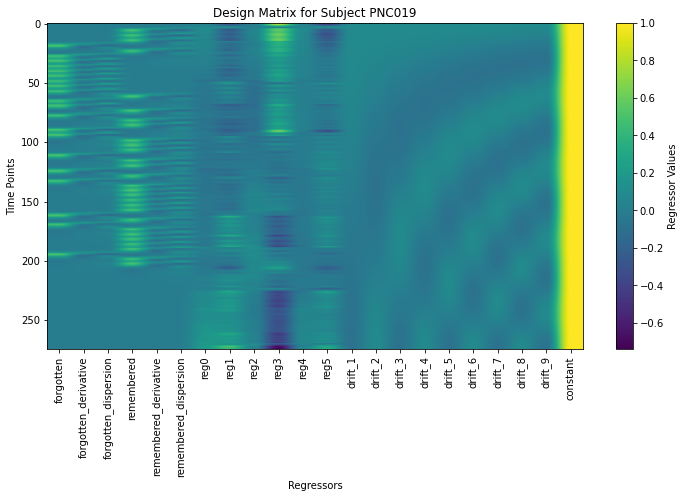

In [43]:
conditions = ['remembered', 'forgotten']
current_task='epiretrieve'

for sub in subs:
    
    # Specify the timing of fmri frames from one example
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiretrieve_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load event files
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    events = pd.read_table(events_file)
    # Recode events to include fixation, stimulus, key press/response to soak up variance
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time','accuracy']]
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress','accuracy': 'trial_type'}, inplace=True)
    # Recode accuracy 
    mapping = {0: 'forgotten', 1: 'remembered'}
    df['trial_type'] = df['trial_type'].replace(mapping)

    
    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'retrieval_uncorrected': (
        basic_contrasts['remembered']
        + basic_contrasts['remembered_derivative']
        + basic_contrasts['remembered_dispersion']),
    'retrieval_corrected': (
        basic_contrasts['remembered']
        - basic_contrasts['forgotten']
        + basic_contrasts['remembered_derivative']
        - basic_contrasts['forgotten_derivative']
        + basic_contrasts['remembered_dispersion']
        + basic_contrasts['forgotten_dispersion'])}
    
    
    ### Load the hippocampal/dentate timeseries ###
    
    # Load the neocortical timeseries and downsample to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiretrieve_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiretrieve/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_epiretrieve_smooth-3mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiretrieve/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_epiretrieve_smooth-3mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        ### fit the design matrix to the data
        labels_, estimates = run_glm(combined_array[0:210, :], design_matrix.values[0:210])

        ### run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
            create_nifti_image(z_score, sub, hemi, contrast_id, hippunfold_dir)
            
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='viridis')
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns[0:210], rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()


# 2.1 Plot to surfaces

In [44]:
#plot hippocampal findings
contrast_names=list(contrasts.keys())
contrasts_epiretrieve = np.ones((483, 2, len(subs), len(contrast_names))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrast_names):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiretrieve/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-epiretrieve_contrast-{contrast_name}.shape.gii'
                try:
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiretrieve[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrast_name}')

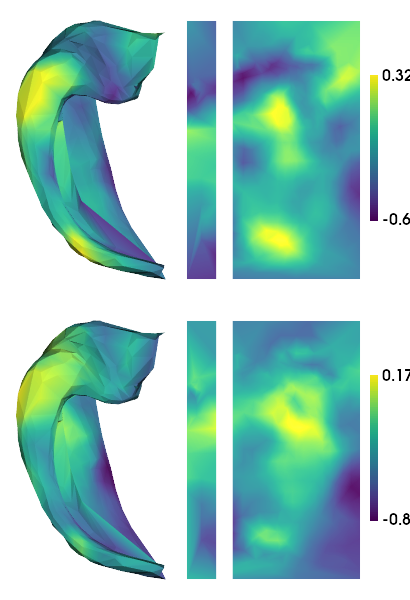

In [45]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiretrieve,axis=(1,2)), hemis=['L'], den='2mm', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

In [46]:
contrasts_epiretrieve_neo = np.ones((len(subs), 2, 2, 200)) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrast_names):
            contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiretrieve/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-epiretrieve_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_epiretrieve_neo[s, c, h] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrast_name}')

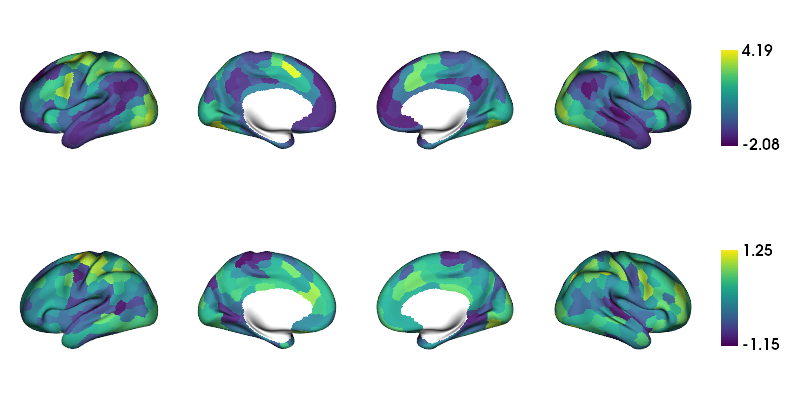

In [47]:
a=np.nanmean(contrasts_epiretrieve_neo,axis=0)
reshaped_a = a.reshape(a.shape[0], a.shape[1] * a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[0]):
    mapped = map_to_labels(reshaped_a[i, :], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, embed_nb=True, nan_color=(1, 1, 1, 1))

# 3. GLM fit for episodic encoding -subsequent memory 

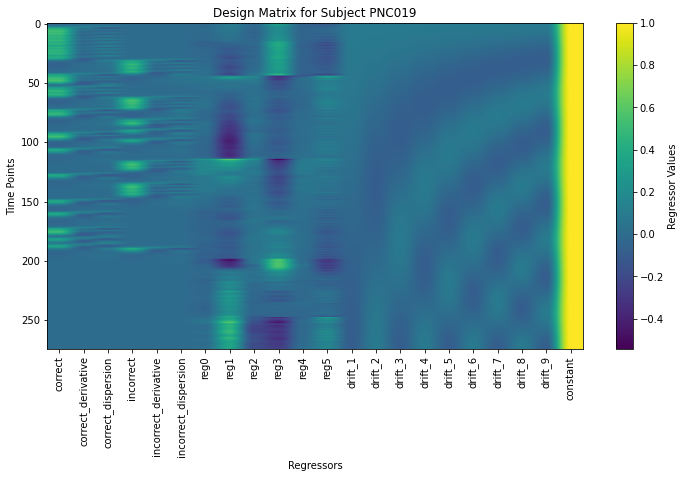

In [48]:
conditions = ['correct', 'incorrect']
current_task='epiencode'
for sub in subs:
    
    # Specify the timing of fmri frames from one example
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiencode_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me.1D')
    frame_times = t_r * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load encoding file
    encoding_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-encoding_events.tsv'
    df_encode = pd.read_table(encoding_file)
    df_encode= df_encode[['event_1_onset','event_1_duration','event_2_onset', 'stim_dur','stim_1','stim_2']]
    df_encode.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'stim_dur': 'duration'}, inplace=True)
    # Load retrieval file
    retrieval_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    df_retrieve = pd.read_table(retrieval_file)
    df_retrieve=df_retrieve[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'accuracy', 'event_3_onset']]
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress','accuracy': 'trial_type'}, inplace=True)
    mapping = {0: 'incorrect', 1: 'correct'}
    df_retrieve['trial_type'] = df_retrieve['trial_type'].replace(mapping)

    new_df = pd.DataFrame()
    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df = new_df.append({'onset': row_encode['onset'],
                                                      'duration': row_encode['duration'],
                                                      'prime': matched_row['prime'],
                                                      'target': matched_row['target'],
                                                      'trial_type': matched_row['trial_type']}, ignore_index=True)
                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    design_matrix = make_first_level_design_matrix(frame_times,
                                      events=new_df,
                                      hrf_model='spm + derivative + dispersion',
                                      add_regs=motion_reg)
    for condition in conditions:
        if condition not in design_matrix.columns:
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'subsequent_memory_uncorrected': (
                        basic_contrasts['correct']
                        + basic_contrasts['correct_derivative']
                        + basic_contrasts['correct_dispersion']),
                    'subsequent_memory_corrected': (
                        basic_contrasts['correct']
                        - basic_contrasts['incorrect']
                        + basic_contrasts['correct_derivative']
                        - basic_contrasts['incorrect_derivative']
                        + basic_contrasts['correct_dispersion']
                        - basic_contrasts['incorrect_dispersion'])}           

    ### Load the hippocampal/dentate timeseries ###
    
    # Load the neocortical timeseries
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-epiencode_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    texture_neo = np.ones((fmri_img_neo.shape[0], 400))
    for i in range(400):
        texture_neo[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)
    neo_tsL = texture_neo[:, :200]
    neo_tsR = texture_neo[:, 200:]
    
    for h, hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiencode/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_epiencode_smooth-3mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiencode/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_epiencode_smooth-3mm.func.gii').darrays[0].data
        
         # Concatenate neocortical hippocampal timeseries column-wise
        if hemi == 'L':
            combined_array = np.hstack((neo_tsL, cdata_hipp, cdata_dg))
        else:
            combined_array = np.hstack((neo_tsR, cdata_hipp, cdata_dg))

        ### fit the design matrix to the data
        labels_, estimates = run_glm(combined_array[0:210, :], design_matrix.values[0:210])

        ### run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()
            create_nifti_image(z_score, sub, hemi, contrast_id, hippunfold_dir)

# make a plot (at the end of the loop so it is the last subject):
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='viridis')
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns[0:210], rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 3.1 Plot to surfaces 

In [49]:
contrast_names=list(contrasts.keys())
contrasts_epiencode= np.ones((483, 2, len(subs), len(contrast_names))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrast_names):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiencode/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-epiencode_contrast-{contrast_name}.shape.gii'
                try:
                    data = nib.load(contrast_file).darrays[0].data
                    contrasts_epiencode[ind[l], h, s, c] = data
                except FileNotFoundError:
                    print(f'Contrast file not found for subject {sub}, hemi {hemi}, label {label}, contrast {contrast_name}')

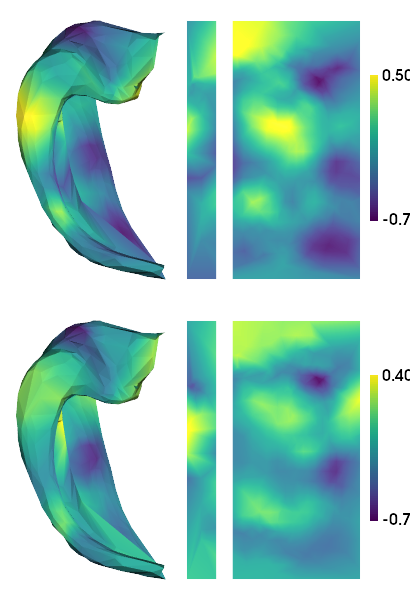

In [50]:
plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), hemis=['L'], den='2mm', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

In [51]:
contrasts_epiencode_neo = np.ones((len(subs), 2, 2, 200)) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrast_names):
            contrast_file = f'{hippunfold_dir}/sub-{sub}/surf/task-fMRI/epiencode/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-epiencode_contrast-{contrast_name}.shape.gii'
            try:
                data = nib.load(contrast_file).darrays[0].data
                contrasts_epiencode_neo[s, c, h] = data  # Corrected indexing
            except FileNotFoundError:
                print(f'Contrast file not found for subject {sub}, hemi {hemi}, contrast {contrast_name}')


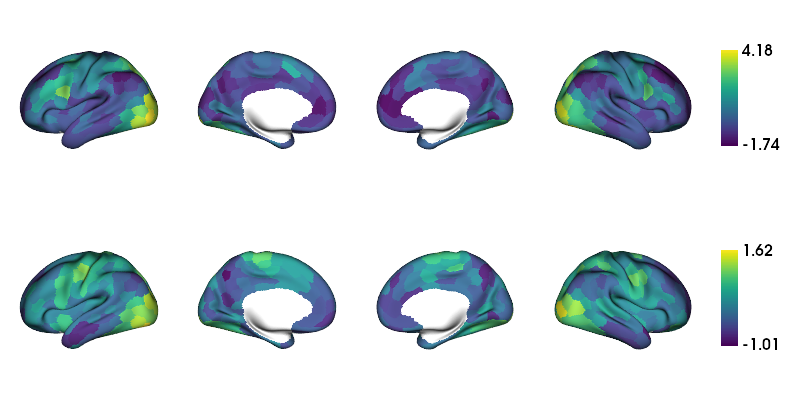

In [52]:
a=np.nanmean(contrasts_epiencode_neo,axis=0)
reshaped_a = a.reshape(a.shape[0], a.shape[1] * a.shape[2])
# vertices to parcels
mapped_data = []
for i in range(reshaped_a.shape[0]):
    mapped = map_to_labels(reshaped_a[i, :], labels_c69, fill=np.nan, mask=mask_c69)
    mapped_data.append(mapped)

plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=mapped_data, 
                 size=(800,200*len(mapped_data)), color_bar=True, embed_nb=True, nan_color=(1, 1, 1, 1))